In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import inconsistent
from scipy.spatial.distance import pdist

In [153]:
df = pd.read_csv('OnlineRetail.csv', encoding="ISO-8859-1")

In [154]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


## Обработка пропущенных значений и приведение типов

In [155]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [156]:
df.dropna(inplace=True)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [158]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [159]:
df['CustomerID'] = df['CustomerID'].astype('object')

In [160]:
df.describe()

,Quantity,UnitPrice
count,406829.000000,406829.000000
mean,12.061303,3.460471
std,248.693370,69.315162
min,-80995.000000,0.000000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [161]:
def convert(x):
    if x < 0:
        return x * -1
    else:
        return x
df['Quantity'] = df['Quantity'].apply(convert)

## Анализ данных

Text(0.5, 1.0, 'Изменение дохода по месяцам')

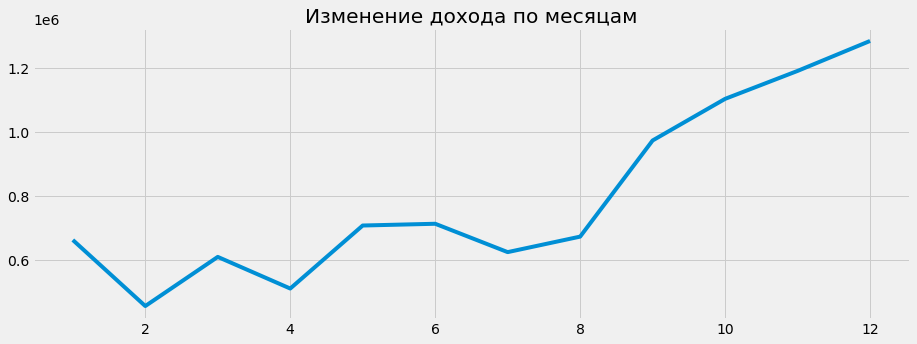

In [162]:
# Всплекс прибыли во время новогодних праздников и падение в январе 
df['Profit'] = df['Quantity'] * df['UnitPrice']
date_profit = df.groupby(df['InvoiceDate'].dt.month)['Profit'].sum()

plt.figure(figsize=(14, 5))
plt.plot(date_profit.index, date_profit)
plt.title('Изменение дохода по месяцам')

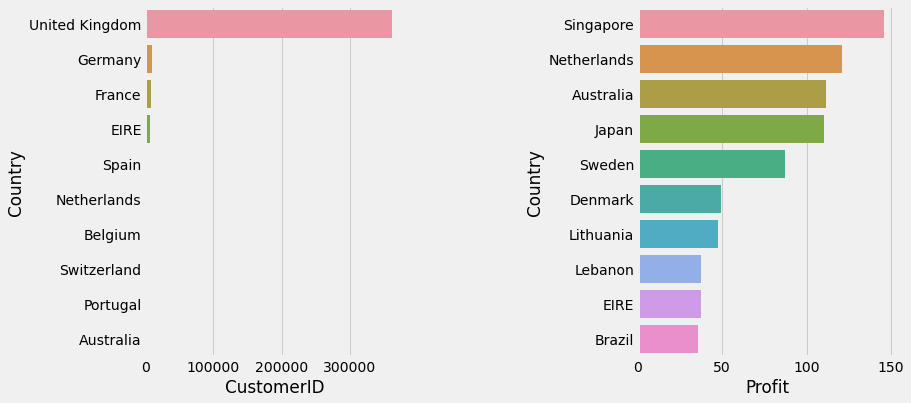

In [163]:
# Самые развитые регионы и регионы с наибольшым зароботком на единицу продукции
most_country = df.groupby('Country')['CustomerID'].count().sort_values(ascending=False).head(10)
d_most_country = (df.groupby('Country')['Profit'].sum() / df.groupby('Country')['Profit'].count()).sort_values(ascending=False).head(10)

fig, ax = plt.subplots(nrows=1, ncols=2) 
ax1, ax2 = ax.flatten()

plt.subplots_adjust(wspace=0.9)
fig.set_size_inches(12, 6)

sns.barplot(most_country, most_country.index, ax=ax1)
sns.barplot(d_most_country, d_most_country.index, ax=ax2 )

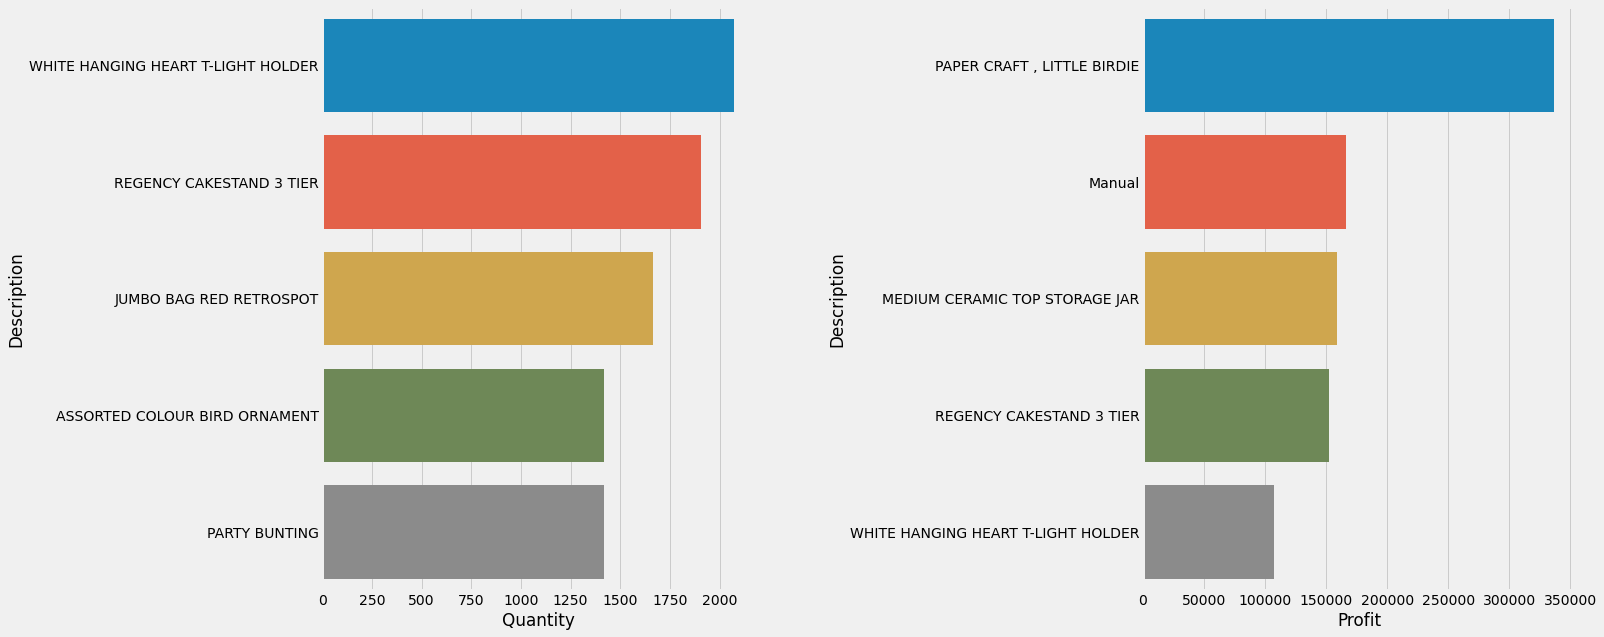

In [164]:
# самый популярный продукт и самый прибыльный
count_descr = df.groupby('Description')['Quantity'].count().sort_values(ascending=False).head(5)
profit_descr = df.groupby('Description')['Profit'].sum().sort_values(ascending=False).head(5)

fig, ax = plt.subplots(nrows=1, ncols=2) 
ax1, ax2 = ax.flatten()

plt.subplots_adjust(wspace=0.9)
fig.set_size_inches(20, 10)

sns.barplot(count_descr, count_descr.index, ax=ax1)
sns.barplot(profit_descr, profit_descr.index, ax=ax2 )

* Обнаруживается разница между самым популярным товаром и самым прибыльным

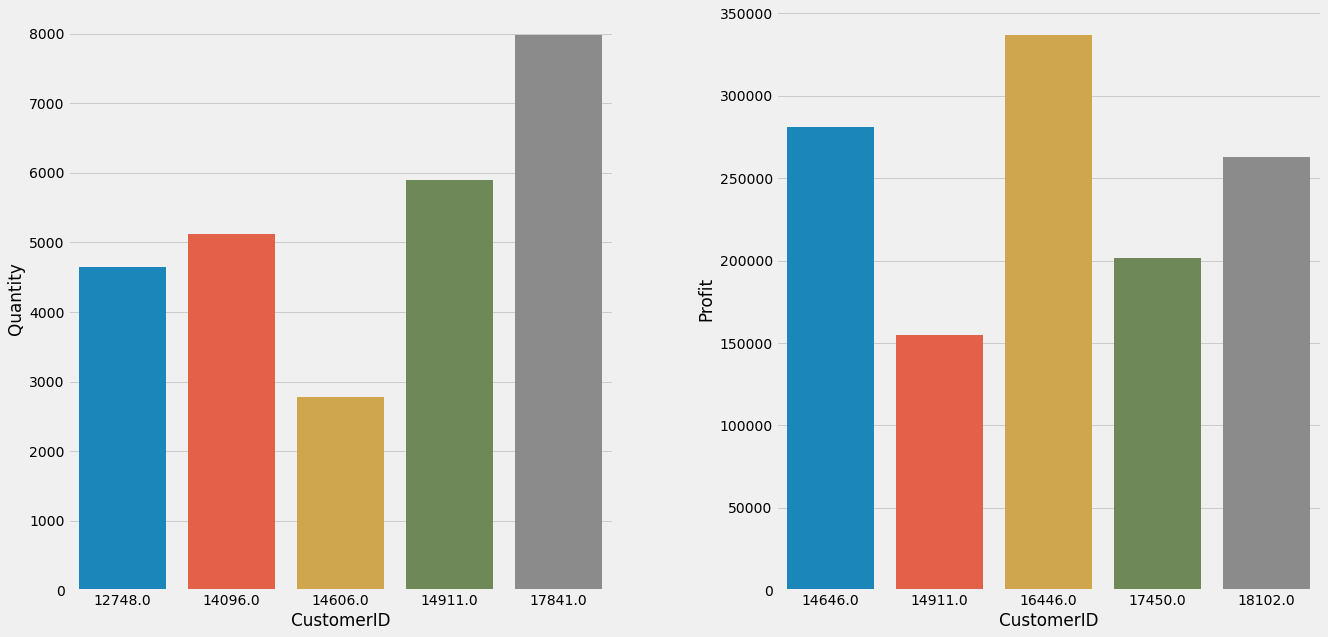

In [165]:
# Воможно будет такое же различие между клиентами
count_cust = df.groupby('CustomerID')['Quantity'].count().sort_values(ascending=False).head(5)
profit_cust = df.groupby('CustomerID')['Profit'].sum().sort_values(ascending=False).head(5)

fig, ax = plt.subplots(nrows=1, ncols=2) 
ax1, ax2 = ax.flatten()

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(20, 10)

sns.barplot( count_cust.index, count_cust, ax=ax1)
sns.barplot(profit_cust.index, profit_cust,  ax=ax2 )

* Так же существует разделение между клиентами, что покупают много и что покупают дорого

## Подготовка таблицы RFM

RFM-анализ — это техника сегментации клиентов, опирающаяся на их поведение. 
* Recency(R) — давность, количество времени с прошлой покупки. 
* Frequency(F) — частота, общее количество покупок. 
* Monetary(M) — деньги, общая сумма покупок.

In [166]:
recuency = df.groupby('CustomerID')['InvoiceDate'].max() 
def date_r(x):
    return df['InvoiceDate'].max() - x
recuency = recuency.apply(date_r)
recuency = recuency.dt.days

In [167]:
frequency = df.groupby('CustomerID')['Quantity'].sum()

In [168]:
monetary = df.groupby('CustomerID')['Profit'].sum()

In [169]:
rfm = pd.merge(pd.merge(recuency, frequency, left_on='CustomerID', right_on='CustomerID', how='left'),
               monetary, how='left', left_on='CustomerID', right_on='CustomerID',)

In [170]:
rfm.columns = ['requency', 'frequency', 'monetary']

In [171]:
scaler = StandardScaler()

scaler.fit(rmf)
rfm[rfm.columns] = scaler.transform(rfm)

rfm

,requency,frequency,monetary
CustomerID,,,
12346.0,340.275109,927594.556493,1.035540e+06
12347.0,1.064781,15361.448138,2.891326e+04
12348.0,77.491799,14630.271791,1.205694e+04
12349.0,18.862853,3943.848263,1.179069e+04
12350.0,323.523982,1231.621473,2.243789e+03
...,...,...,...
18280.0,290.021727,281.717159,1.212054e+03
18281.0,188.468017,337.961493,5.427006e+02
18282.0,7.346453,675.427500,1.204675e+03


In [172]:
rfm.describe()

,requency,frequency,monetary
count,4372.000000,4.372000e+03,4.372000e+03
mean,95.339202,7.800064e+03,1.461201e+04
std,105.495915,3.675337e+04,7.045217e+04
min,0.017835,6.744858e+00,5.366185e-01
25%,16.768962,9.941454e+02,2.070514e+03
50%,51.318163,2.369007e+03,4.548589e+03
75%,148.684090,6.215494e+03,1.137971e+04
max,390.528491,1.239019e+06,2.260306e+06


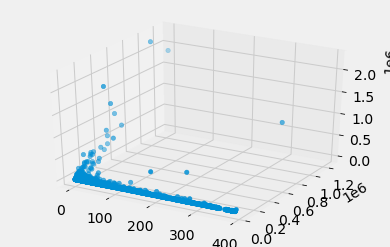

In [173]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['requency'], rfm['frequency'], rfm['monetary'])

Четкое распределение на кластеры не наблюдается и у модели есть выбросы.
* Обработая выбросы с помощью квантилей
* И построю 2 алгоритма для разделения на кластеры: KMeans и Hierarchy

In [174]:
# Обработка выбросов
def requency_q(x):
    if x > rfm['requency'].quantile(.95):
        return rfm['requency'].quantile(.95)
    elif x < rfm['requency'].quantile(.05):
        return rfm['requency'].quantile(.05)
    else:
        return x
    

rfm['requency'] = rfm['requency'].apply(requency_q)

In [175]:
def frequency_q(x):
    if x > rfm['frequency'].quantile(.95):
        return rfm['frequency'].quantile(.95)
    elif x < rfm['frequency'].quantile(.05):
        return rfm['frequency'].quantile(.05)
    else:
        return x
    

rfm['frequency'] = rfm['frequency'].apply(frequency_q)

In [176]:
def monetary_q(x):
    if x > rfm['monetary'].quantile(.95):
        return rfm['monetary'].quantile(.95)
    elif x < rfm['monetary'].quantile(.05):
        return rfm['monetary'].quantile(.05)
    else:
        return x
    

rfm['monetary'] = rfm['monetary'].apply(monetary_q)

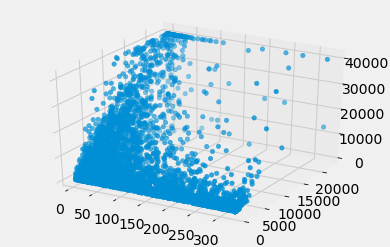

In [177]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['requency'], rfm['frequency'], rfm['monetary'])

## Построение модели и визуализация количества кластеров

### Kmeans

In [178]:
avg = []
ssd = []
for i in range(2, 10):
    Kmeans = KMeans(n_clusters=i, random_state=42, max_iter=60)
    Kmeans.fit(rmf)
    y_labels = Kmeans.labels_
    
    silhouette_avg = silhouette_score(rfm, y_labels)
    
    avg.append(silhouette_avg)
    ssd.append(Kmeans.inertia_)
    
pd.DataFrame(avg, columns=['silhouette'])

,silhouette
0,-0.076148
1,-0.216773
2,-0.223008
3,-0.081354
4,-0.119082
5,-0.139831
6,-0.151820
7,-0.100787


* Алгоритм показывает наилучшее количество кластеров - 3

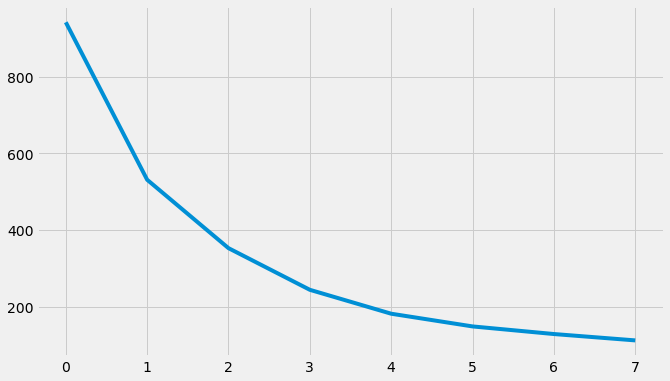

In [179]:
ssd = pd.DataFrame(ssd, columns=['SSD'])

#Возьмём 3 кластера
plt.figure(figsize=(10,6))
plt.plot(ssd)

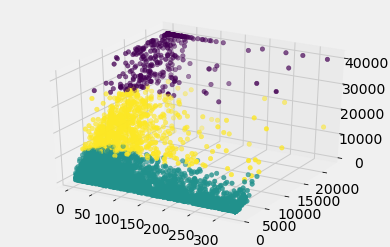

In [180]:
Kmeans = KMeans(n_clusters=3, random_state=42, max_iter=60)
Kmeans.fit(rfm)
y_labels = Kmeans.labels_

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['requency'], rfm['frequency'], rfm['monetary'], c=y_labels)

In [181]:
rfm_kmeans = rfm.copy()
rfm_kmeans['Cluster'] = y_labels
rfm_kmeans['Cluster'] = rfm_kmeans['Cluster'].astype('object')
rfm_kmeans

,requency,frequency,monetary,Cluster
CustomerID,,,,
12346.0,326.664818,22472.606812,40156.411784,0
12347.0,2.111726,15361.448138,28913.264761,0
12348.0,77.491799,14630.271791,12056.943005,2
12349.0,18.862853,3943.848263,11790.690991,2
12350.0,323.523982,1231.621473,2243.788658,1
...,...,...,...,...
18280.0,290.021727,281.717159,1212.053719,1
18281.0,188.468017,337.961493,741.866347,1
18282.0,7.346453,675.427500,1204.674600,1


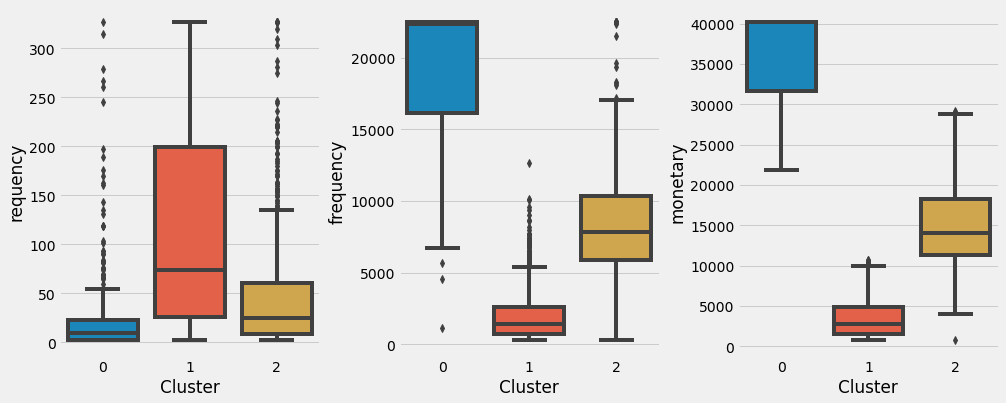

In [182]:
fig, ax = plt.subplots(nrows=1, ncols=3)


plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(15, 6)

sns.boxplot(x='Cluster', y='requency', data=rfm_kmeans, ax=ax[0])
sns.boxplot(x='Cluster', y='frequency', data=rfm_kmeans, ax=ax[1])
sns.boxplot(x='Cluster', y='monetary', data=rfm_kmeans, ax=ax[2])



Выводы разделения:
* 2-ой кластер - клиенты на которых нужно ориентироваться - покупают часто, много и тратят больше остальных.
* в 1-м кластере люди, что мало и давно покупали
* 0-ой кластер - обычные средние клиенты.

### Hierarchy

In [183]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

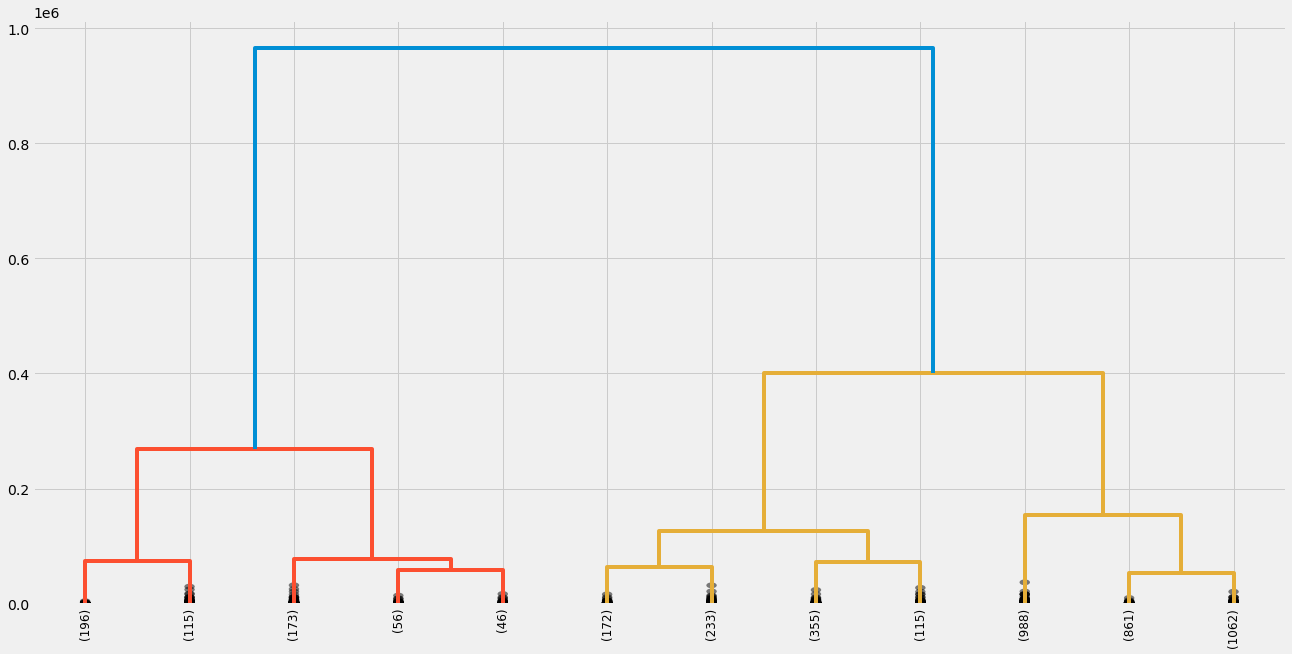

In [184]:
distance_mat = pdist(rfm) # pdist посчитает нам верхний треугольник матрицы попарных расстояний

Z = hierarchy.linkage(distance_mat, 'ward') # linkage — реализация агломеративного алгоритма
plt.figure(figsize=(20, 10))
dn = hierarchy.dendrogram(Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True)

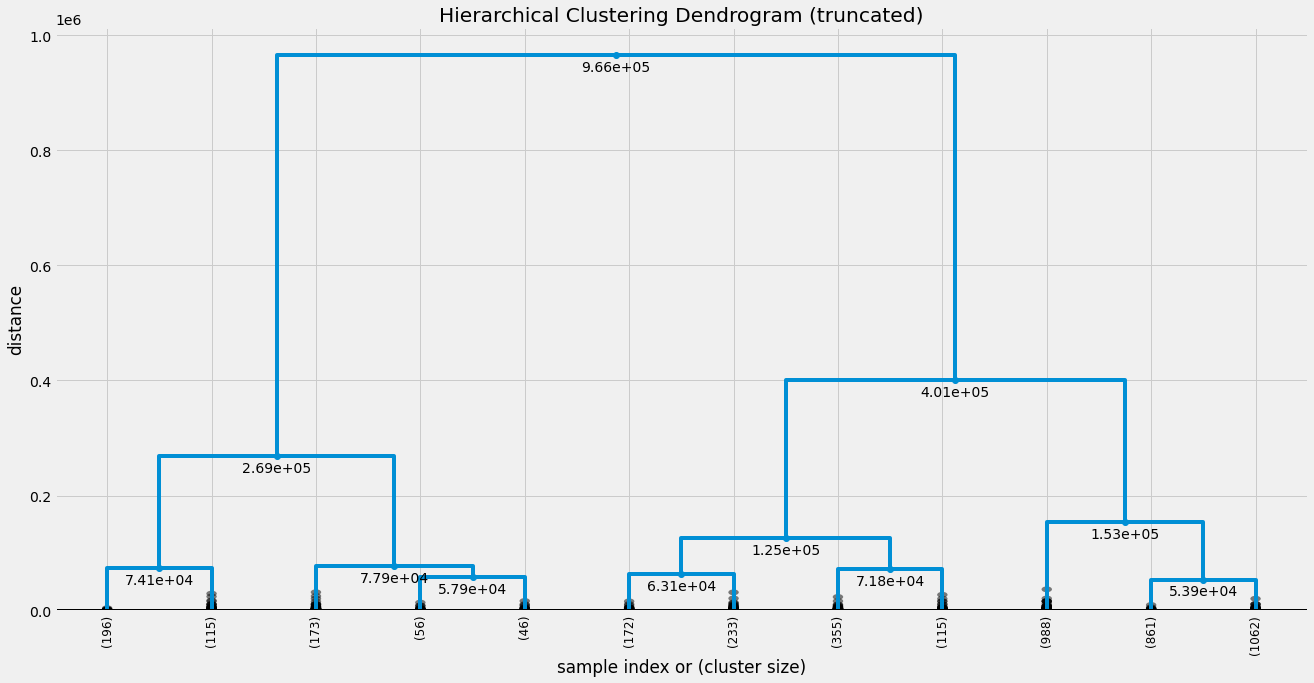

In [185]:
max_d = 20
plt.figure(figsize=(20, 10))
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

In [198]:
from scipy.cluster.hierarchy import fcluster
max_d = 0.4 * 1e6
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([1, 1, 2, ..., 3, 2, 2], dtype=int32)

In [199]:
rfm_hierarchy = rfm.copy()
rfm_hierarchy['Cluster'] = clusters
rfm_hierarchy['Cluster'] = rfm_hierarchy['Cluster'].astype('object')
rfm_hierarchy

,requency,frequency,monetary,Cluster
CustomerID,,,,
12346.0,326.664818,22472.606812,40156.411784,1
12347.0,2.111726,15361.448138,28913.264761,1
12348.0,77.491799,14630.271791,12056.943005,2
12349.0,18.862853,3943.848263,11790.690991,2
12350.0,323.523982,1231.621473,2243.788658,3
...,...,...,...,...
18280.0,290.021727,281.717159,1212.053719,3
18281.0,188.468017,337.961493,741.866347,3
18282.0,7.346453,675.427500,1204.674600,3


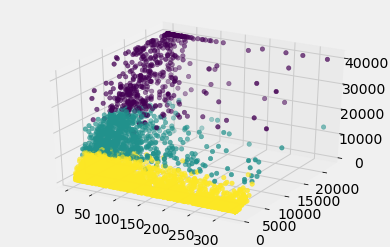

In [200]:
# Разделение прошло несколько иначе
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm['requency'], rfm['frequency'], rfm['monetary'], c=clusters)

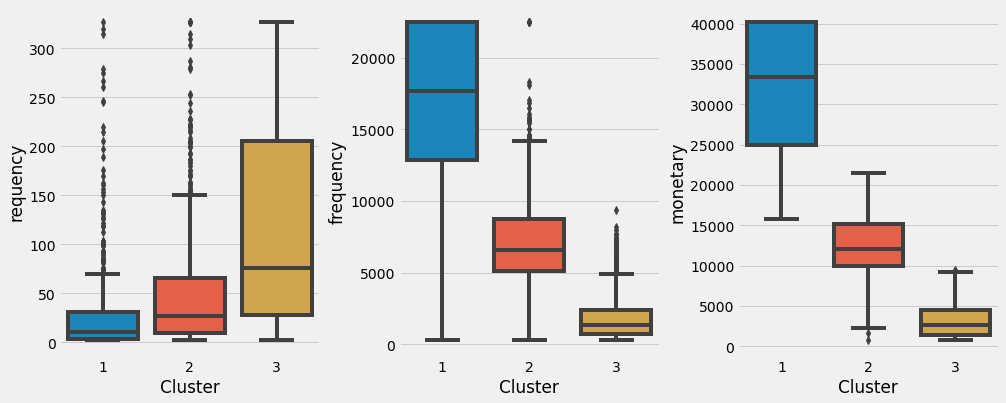

In [201]:
fig, ax = plt.subplots(nrows=1, ncols=3)

plt.subplots_adjust(wspace=0.3)
fig.set_size_inches(15, 6)

sns.boxplot(x='Cluster', y='requency', data=rfm_hierarchy, ax=ax[0])
sns.boxplot(x='Cluster', y='frequency', data=rfm_hierarchy, ax=ax[1])
sns.boxplot(x='Cluster', y='monetary', data=rfm_hierarchy, ax=ax[2])

Выводы:
* 3-ий кластер - клиенты, которые покупают давно, мало и дешево.
* 1-ый - которые покупают много часто и дорого
* 2-ой - среднее между 3-м и 1-ым

**Алгоритмы показали практически индентичные результаты**

In [203]:
rfm_hierarchy.to_csv('rfm_h.csv')